In [1]:
import random
import functools
from typing import List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
"""
Just a few utility functions that we will need later to draw the game
"""


def hex_to_rgb(h: str) -> tuple:
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))


def rgb_to_hex(rgb: tuple) -> str:
    return "#{:02x}{:02x}{:02x}".format(*rgb)


def interpolate(rgb1: tuple, rgb2: tuple, n_steps: int) -> np.ndarray:
    rgb1 = np.array(rgb1).reshape(1, -1)
    rgb2 = np.array(rgb2).reshape(1, -1)
    return (rgb1 + np.linspace(0, 1, n_steps).reshape(-1, 1) * (rgb2 - rgb1)).astype(np.uint8)

In [3]:
"""
Populating a board in this context simply means spawning a new tile, which has a value of 2 in 90% of 
cases and a value of 4 otherwise
"""


def populate(board: np.ndarray) -> np.ndarray:
    flat_board = np.copy(board.reshape(-1,))
    free_indices = np.argwhere(flat_board == 0).reshape(-1,)
    selected_idx = np.random.choice(free_indices)
    u = random.uniform(0, 1)
    # 10% chance of getting a 4 instead of a 2
    val = 2 if u > 0.9 else 1
    flat_board[selected_idx] = val
    return flat_board.reshape(board.shape)

In [4]:
def move_down(col: List[int]):
    
    score = 0
    new_col = list()
    n = len(col)
    i = n - 1
    
    while i >= 0:
        val = col[i]
        if val == 0:
            i -= 1
            continue
        ii = i - 1
        if ii < 0:
            new_col.append(val)
            break
        while col[ii] == 0:
            ii -= 1
        if ii < 0:
            new_col.append(val)
            break
        if col[ii] == val:
            new_val = 2 * val
            score += new_val
            new_col.append(new_val)
            i = ii - 1
        else:
            new_col.append(val)
            i = ii
    
    new_col = new_col + [0 for _ in range(n - len(new_col))]
    new_col = new_col[::-1]
    
    # Taking log2
    new_col = np.array(new_col)
    not_empty = new_col > 0
    new_col[not_empty] = np.log2(new_col[not_empty]).astype(int)
    
    return {
        "next": new_col,
        "score": score
    }


def move_up(col: List[int]):
    res = move_down(col[::-1])
    res["next"] = res["next"][::-1]
    return res


def move_right(row: List[int]):
    return move_down(col=row)


def move_left(row: List[int]):
    return move_up(col=row)

In [5]:
class GameState:
    
    def __init__(self):
        # Game board is going to be a numpy array of size 4x4
        # Each cell stores the log of the value (base 2)
        self._board = None
        self.reset_board()
        self._board = populate(self._board)
    
    @property
    def board(self) -> np.ndarray:
        board = 2 ** self._board
        board[board == 1] = 0
        return board
    
    def reset_board(self) -> None:
        self._board = np.zeros((4, 4), dtype=int)
        
    def attemp(self, what: str) -> Optional[np.ndarray]:
        
        action = {
            "down": (move_down, np.column_stack, True),
            "up": (move_up, np.column_stack, True),
            "right": (move_right, np.row_stack, False),
            "left": (move_left, np.row_stack, False)
        }.get(what)
        
        if action is None:
            raise ValueError("Unknown movement")
        
        move_fn, stack_fn, transpose = action
        
        def t(b: np.ndarray):
            if transpose:
                return b.T
            return b
        
        cols = [col for col in t(self.board)]
        results = [move_fn(col) for col in cols]
        new_cols = [res["next"] for res in results]
        new_board = stack_fn(new_cols)
        
        if (new_board == self._board).all():
            return None, 0
        
        score = sum([res["score"] for res in results])
        return new_board, score
    
    def set_new_board(self, new_board: np.ndarray) -> None:
        self._board = populate(new_board)

In [6]:
class Game:
    
    def __init__(self):
        self.game_state = GameState()
        self.score = 0
        self.is_over = False
    
    @property
    def board(self) -> np.ndarray:
        return self.game_state.board
    
    @functools.cache
    def admissible_moves(self):
        all_moves = ["left", "right", "up", "down"]
        moves = dict()
        for move in all_moves:
            new_board, score = self.game_state.attemp(move)
            if new_board is not None:
                moves[move] = (new_board, score)
        return moves
    
    def move(self, what: str) -> bool:
        
        # Return wether or not the action was succesfully executed
        
        if self.is_over:
            return False
        
        moves = self.admissible_moves()
        if what not in moves:
            return False
        
        # Guaranteed to be not None
        new_board, score = moves[what]
        self.game_state.set_new_board(new_board)
        self.score += score
        
        # Is it over? Get next admissible moves and check!
        self.admissible_moves.cache_clear()
        next_moves = self.admissible_moves()
        if len(next_moves) == 0:
            self.is_over = True
            
        return True

## Play the game

In [7]:
from ipywidgets import *

<IPython.core.display.Javascript object>


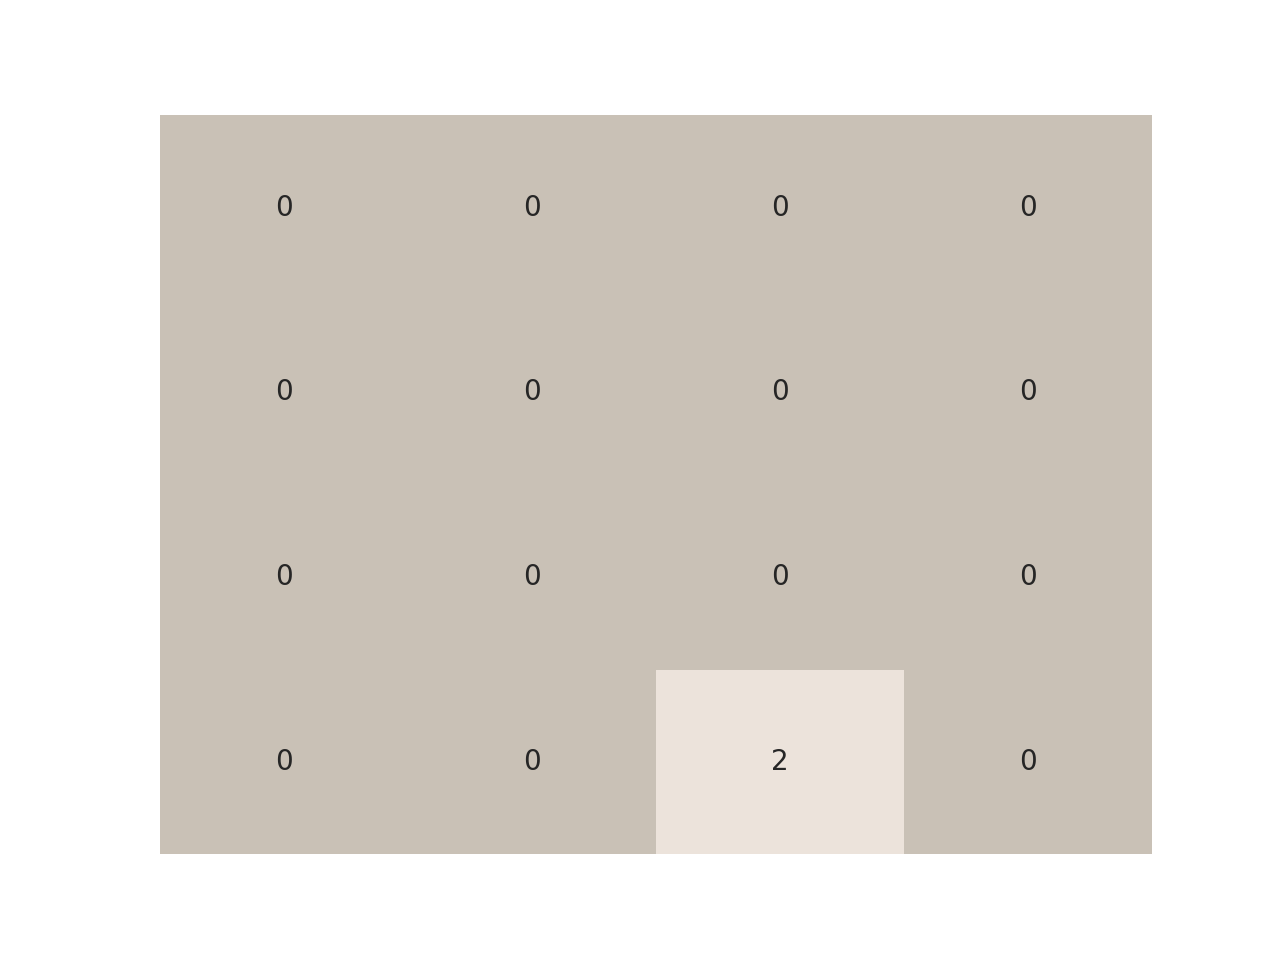

In [8]:
%matplotlib notebook

fig, ax = plt.subplots()
game = Game()

colors = [
    '#c9c1b6',
    '#ece3db',
    '#ece3db',
    '#e8b381',
    '#df9260',
    '#e58367',
    '#d96243',
    '#eeda7b'
]
bounds = [0] + [2 ** i for i in range(1, len(colors))]

# According to Wikipedia, 2^17 is the largest possible value of a tile
remaining = list(range(len(colors), 17+1))

# The color interpolation is just a heuristic
# - no idea what color palette the game actually uses
additional_colors = [
    rgb_to_hex(rgb)
    for rgb in interpolate(
        rgb1=hex_to_rgb(colors[-1]),
        rgb2=(128, 120, 40),
        n_steps=len(remaining)
    )
]
additional_bounds = [2 ** i for i in remaining]

colors = colors + additional_colors
bounds = bounds + additional_bounds

cmap = ListedColormap(colors)

norm = BoundaryNorm(bounds, cmap.N)


def heatmap():
    sns.heatmap(
        game.board,
        annot=True,
        cmap=cmap,
        norm=norm,
        cbar=False,
        xticklabels=False,
        yticklabels=False,
        ax=ax
    )

    
heatmap()
ax.set_title("")

keys = ["left", "right", "up", "down"]
labels = ["Left", "Right", "Up", "Down"]

options = dict(zip(keys, labels))

buttons = {
    what: Button(description=desc)
    for what, desc in options.items()
}

hbox = HBox([buttons[what] for what in keys])
display(hbox)


def update(what):
    success = game.move(what)
    score_str = "Score: {}".format(game.score)
    if success:
        ax.cla()
        heatmap()
        ax.set_title(score_str)
    if game.is_over:
        ax.set_title("{} - GAME OVER!".format(score_str))

        
def on_button_clicked(what: str):
    def closure(b):
        update(what)
    return closure
        
    
for what, button in buttons.items():
    button.on_click(on_button_clicked(what))